# The Three Body Problem  
Using Verlet intergration evolve a 3 body system for position and velocity.  
Calculate angular momentum of the bodies.  
Calculate total energy (potential and kinetic).  
### Verlet  
velocity half step  
$ v_{n+\frac{1}{2}} = v_n +\frac{1}{2} ha (x_n) $  
$ x_{n+1} = x_n +hv_{n+\frac{1}{2}} $  
$ v_{n+1} = v_{n+\frac{1}{2}} +\frac{1}{2} ha (x_{n+1}) $  

$ h $ is timestep  
$ a(x) $ is acceleration at point x. I will calulate using the force function defined near the top, and divide it by mass. So that it in keeping with the other solvers here.

In [2]:
#pip install numpy
#pip install matpoltlib
#pip install scipy
#pip install cycler
#pip install pandas
#pip install timeit
#pip install os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scipy.constants as sc
import pandas as pd
import timeit
import os
from scipy.optimize import curve_fit

### Functions

#### Data saving

In [6]:
def Data_save(p, v, E, L, t, c, f_name):
    """Function for saving positions, velocity, energy and angular momentum produced to a txt file.
    IN:
        p: An array holding all of the positions of that timestep. [x,y]
        v: An array holding all the velocities of that timestep. [x,y]
        E: Total energy of the system.
        L: Total angular momentum of the system.
        t: Time of the particular step.
        c: Centre of mass
        f_name: The file the data is being saved to."""
    f = open(f_name, "a")
    f.write("\n")
    for i in range(len(p)):
        f.write(f"{p[i,0]}" + "\t" + f"{p[i,1]}" + "\t")
        
    for i in range (len(p)):
            f.write(f"{v[i,0]}" + "\t" + f"{v[i,1]}" + "\t")

    f.write(f"{E}" + "\t" + f"{L}" + "\t" + f"{t}" + "\t" + f"{c[0]}" + "\t" + f"{c[1]}")
    f.close()


#### Energies

In [8]:
def Grav_eng(pos_e, ma_e, pos_other, ma_other, ep, G):
    """Grav_eng(pos_e, ma_e, pos_other, ma_other):
    Calculates tthe gravtiational energy between two bodies.
    U = -GMm/(r+ep)
    IN:
        pos_e: position of the planet in question. [x,y]
        ma_e: mas of the planet in question.
        pos_other: position of the other planet. [x,y]
        ma_other: mas of the other planet.
        ep: extra bit to make sure the numbers dont blow up to much at low distances.
        G: GRavitational constant.
    OUT:
        g_e: gravitational potential energy."""
    
    dif = pos_other-pos_e
    g_e = -(G * ma_e *ma_other) / (np.linalg.norm(dif+ep))

    return g_e

In [9]:
def Kin_eng(vel_e, m_e):
    """Kin_eng(vel_e, m_e):
    Calculate the kinetic energy.
    E = 0.5mv^2
    IN:
        vel_e: velocity of a body. [vx,vy]
        m_e: mass of the planet in question.
    OUT:
        k_e: Kinetic energy of the body."""
    
    k_e = 0.5*m_e*(vel_e**2)
    k_e = np.linalg.norm(k_e)

    return k_e

#### Angular momentum

In [11]:
def Angular_momentum(p, v, m):
    """Angular_momentum(p, v, m):
    A function which calculates the angular momentum of the system.
    L = r x vm
    IN:
        p: position of the bodies.
        v: velocity of the bodies.
        m: mass of the bodies 
    OUT:
        a_m: total angular momentum for a time step."""

    rxv = np.cross(p,v)
    L = m * rxv
    
    return np.sum(L)

#### Force

In [13]:
def Force( ma_f, pos_f, ep, G):
    """Force( ma_f, pos_f, ep, G):
    A function for calculating a matricx of the gravitational force between bodies.
    F = GMm/r^2
    IN:
        ma_f: An array of all of the planetary masses.
        pos_f: position of the bodies. [x,y]
        ep: extra bit to make sure the numbers dont blow up to much at low distances.
        G: Gravitational constant.
    OUT:
        mat: a square matrix of the force between the planets"""
    size = len(ma_f)
    mat = np.zeros((size,size), dtype='object')
    mat[:] = 0
    for i in range(size):
        for j in range(size):
            if i==j:
                mat[i,j]=0
            else:
                mx = ma_f[i]
                my = ma_f[j]
                #dif = np.abs(pos[i]-pos[j])
                dif = (pos_f[i]-pos_f[j])
                force =  -G*mx*my*dif / (np.linalg.norm(dif + ep)**3)
                #print(f" {i},{j} {force}")
                mat[i,j] = mat[i,j]+force
                
    #print(f"force matrix {mat}")
    
    mat = np.sum(mat, axis=1)
    #print(f" force {mat}")
    return mat

#### Centre of mass

In [15]:
def COM(ps, mas):
    """A function which calculates the x adn y components of the centre of mass.
    x_com = sum(x_i * mas_i)/sum(mas)
    In:
        ps: An array of the coorrdinates of the bodies.
        mas: an array of the masses of the bodies.
    Out:
        com: corrdinates of the center of mass.[x,y]"""
    sum_mas = np.sum(mas)
    #print(f"mas {mas}")
    #print(f"ps {ps}")
    psma = ps * mas[:, np.newaxis]
    sum_ps = np.sum(psma, axis=0)
    com = sum_ps/sum_mas
    
    return com

#### Semi major axis

In [17]:
def Semi_major(sem_pos_x, sem_pos_y, sem_com_x, sem_com_y):
    """A function which calculates the semi major axis by finding the amximum distance between the planets and the centre of mass.
    In:
        sem_pos_x: x coordinate of the planet.
        sem_pos_y: y coordinate of the planet.
        sem_com_x: cetre of mass x coordinate.
        sem_com_y: centre of mass y coordinate.
    Out:
        sem_maj: Semi major axis"""
    sem_pos = np.linalg.norm((sem_pos_x,sem_pos_y), axis=0)
    sem_com = np.linalg.norm((sem_com_x,sem_com_y), axis=0)
    sep = sem_pos-sem_com
    sem_index = np.argmax(sep)
    if sem_index == len(sep):
        return 0
    sem_maj = sep[sem_index]
    return sem_maj

#### Period

In [19]:
def Period(per_x, per_y, per_time):
    """A function for calucating the orbital period of a planet.
    In:
        per_x: x coordinates.
        per_y: y coordinates.
        per_time: time of each step."""
    in_pos_x = per_x[0]
    in_pos_y = per_y[0]
    for p in range(15000, len(per_time)):
        current_pos_x = per_x[p]
        current_pos_y = per_y[p]
        #if (in_pos_x-current_pos_x)<x_dif and (in_pos_y-current_pos_y)<y_dif:
        #    x_dif = in_pos_x-current_pos_x
        #    y_dif = in_pos_y-current_pos_y
        
        sep = np.sqrt((current_pos_x - in_pos_x)**2 + (current_pos_y - in_pos_y)**2)

        if sep < 1e-5:
            return per_time[p]
    
    return 0

            
        

#### Kerplers third law

In [21]:
def Keplers_third(na):
    """A function for testing the simulations against keplers third law.
    In:
        na: Names of teh simulations"""
    
    t1 = timeit.default_timer()
    fig =  plt.figure()
    ax = fig.add_subplot()
    
    produced_data_directory = "n_body_data/"
    if os.path.exists(produced_data_directory) == False:
        raise ImportError(f"The directory {produced_data_directory} does not exist. Running simulations will produce it")
            
    file_list = os.listdir(produced_data_directory)
    per_sqr = np.array([])
    sem_cub = np.array([])
    for K in range(len(na)):
        file = f"n_body_data/produced_data_system_{na[K]}.txt"
        if os.path.exists(file) == False:
            continue
            
        else:
            orbit_data=pd.read_csv(file, sep="\s+")
            semi_major_axis = Semi_major(sem_pos_x = orbit_data["p1x"], sem_pos_y = orbit_data["p1y"], sem_com_x = orbit_data["comx"], sem_com_y = orbit_data["comy"])
            period = Period(per_x = orbit_data["p1x"], per_y = orbit_data["p1y"], per_time = orbit_data["time"])
            if period==0:
                continue

            per_sqr = np.append(per_sqr, period**2)
            sem_cub = np.append(sem_cub, semi_major_axis**3)
            print(f"system {na[K]}, period {period}, semi_makor_axis {semi_major_axis}")
    G = 1
    best_fit,covariance = curve_fit(Line, per_sqr, sem_cub)
    x_line = np.linspace(0,np.max(per_sqr), 1000)
    ax.plot(x_line, Line(best_fit[0], x_line, best_fit[1]), linestyle = "dashed", color = "k", label = "best fit")
    ax.plot(x_line, Line((1/(4*np.pi**2)), x_line, 0), linestyle = "dashed", color = "Red", label =r"$\frac{GM}{4 {\pi}^2} $" )
    ax.scatter(per_sqr, sem_cub, color = "Blue")
    ax.set_xlabel(r" $ p^2 $ ")
    ax.set_ylabel(r" $ a^3 $ ")
    ax.set_title("period vs semi-major axis")
    ax.legend(loc = "lower right")
    
    fig.tight_layout()
    fig.savefig(f"n_body_plots/Keplers_third.png", dpi=250)
    plt.close(fig)
    t2=timeit.default_timer()
    print(f"Keplers_third time taken {t2-t1}")

In [22]:
def Line(m,x,c):
    return(m*x+c)

#### Verlet step

In [24]:
def Verlet(pos_v, vel_v, ma, ep, G, t_s):
    """A function that runs a single loop of a verlet integrator.
    IN:
        pos_v: an array holding the positions of all the planets at the beginning of a time step.
        vel_v: an array holding the velocities at the beginning of a time step.
        ma: an array holding the mass of all of the planets.
        ep: extra bit to make sure the numbers dont blow up too much at low distances.
        G: gravitational constant.
        t_s: time step.

    OUT:
        pos_full: an array holding the position of all the bodies at the end of a time step
        vel_full: an array holding the velocities of all the bodies at the end of a time step
    """

    pos_full = np.array([])
    vel_full = np.array([])
    vel_half = np.array([])
    kinetic = np.array([])
    gravitational = np.array([])
    # Calculating halfstep forces
    f_half = Force(ma_f=ma, pos_f=pos_v, ep=ep, G=G)

    # Calculate half-step velocities and full-step positions
    for v in range(len(ma)):
        v_h = vel_v[v] + (0.5 * t_s * f_half[v]/ma[v])
        p_full = pos_v[v] + (t_s * v_h)
        
        # Store half-step velocity
        if vel_half.shape == (0,):
            vel_half = np.array([v_h])
        else:
            vel_half = np.vstack((vel_half, np.array([v_h])))
            
        # Store full-step position
        if pos_full.shape == (0,):
            pos_full = np.array([p_full])
        else:
            pos_full = np.vstack((pos_full, np.array([p_full])))
    
    # Calculating full step forces
    f_full = Force(ma_f=ma, pos_f=pos_full, ep=ep, G=G)

    # Calculate full-step velociteis using stored half-step velocities
    for ve in range(len(ma)):
        v_full = vel_half[ve] + (0.5 * t_s * f_full[ve]/ma[ve])

        # Storing full step velocities
        if vel_full.shape == (0,):
            vel_full = np.array([v_full])
        else:
            vel_full = np.vstack((vel_full, np.array([v_full])))
        # Calcaulting energies
        kinetic = np.append(kinetic, Kin_eng(v_full, ma[ve]))
        gravitational = np.append(gravitational, Grav_eng(pos_full[ve], ma[ve], pos_full, ma, ep, G))

    kinetic = np.sum(kinetic)
    gravitational = np.sum(gravitational)
    return pos_full, vel_full, gravitational, kinetic

### Main

#### Simulating

In [27]:
def Running_simulations(da, si, na):
    """Function which runs the verlet nbody simulations.
    In:
        da: Input data.
        si: Simulations to run.
        na: names fo the simualtions"""
    
    print(f"number of simulations running {len(si)}")
    for s in range(len(si)):

        #Selecting input data
        r = si[s]
        in_con = da.iloc[r]
        name = na[r]

        
        masses = np.array([in_con.loc["m1"], in_con.loc["m2"], in_con.loc["m3"]])
        i_positions = np.array([[in_con.loc["pos1x"],in_con.loc["pos1y"]], [in_con.loc["pos2x"],in_con.loc["pos2y"]], [in_con.loc["pos3x"],in_con.loc["pos3y"]]])
        i_velocities = np.array([[in_con.loc["vel1x"],in_con.loc["vel1y"]], [in_con.loc["vel2x"],in_con.loc["vel2y"]], [in_con.loc["vel3x"],in_con.loc["vel3y"]]])
        
        
        fin = in_con.loc["period"] * 1.5
        time_step = in_con.loc["tstep"]
        no_steps = round(fin/time_step)
        
        print(f"Simulation {name}, system {r}, {no_steps} steps")
        
        epsilon = in_con.loc["epsilon"]
        stated_energy = in_con.loc["energy"]
        stated_angmom = in_con.loc["angmom"]
        G = 1

        for i in range(len(masses)):
            if masses[i] == 0:
                masses = np.delete(masses, i)
                i_positions = np.delete(i_positions, i, 0)
                i_velocities = np.delete(i_velocities, i, 0)

        # making a folder to hold produced data
        if os.path.exists("n_body_data") == False:
            os.makedirs("n_body_data")
            print("folder 'n_body_data' created")

        # Making a data file
        file_name = f"n_body_data/produced_data_system_{name}.txt"
        file = open(file_name, "w")
    
        for a in range(len(masses)):
            file.write(f"p{a+1}x" + "\t" + f"p{a+1}y" + "\t")
        
        for a in range(len(masses)):
            file.write(f"v{a+1}x" + "\t" + f"v{a+1}y" + "\t")
    
        file.write("Energy" + "\t" + "Ang_mom" + "\t" + "time" + "\t" + "comx" + "\t" + "comy")
        
        file.close()
    
        pos = i_positions
        vel = i_velocities
    
    
        tot_eng=stated_energy
        ang_mom=stated_angmom
        
        t1 = timeit.default_timer()

        # Running the Verlet intergrator
        for i in range(no_steps):
            if i%500000 == 0 and i!=0:
                t3 = timeit.default_timer()
                print(f"step {i}, time taken {t3-t1}")
                
            time = i *time_step
            centre_of_mass = COM(pos, masses)
            
            Data_save(p=pos, v=vel, E=tot_eng, L=ang_mom, t=time, c=centre_of_mass, f_name = file_name)
        
            new_pos, new_vel, gravitational_energy, kinetic_energy = Verlet(pos_v=pos, vel_v=vel, ma=masses, ep=epsilon, G=G, t_s=time_step)     #Calling verlet intergrator
        
            ang_mom = Angular_momentum(p = new_pos, v = new_vel, m = masses)
            tot_eng = kinetic_energy + np.sum(gravitational_energy)
    
            pos = new_pos
            vel = new_vel
        
    
        t2 = timeit.default_timer()
        print(f"system {r} time taken {t2-t1}")

#### Plotting

In [29]:
def Plotting_simualtions(pl,na):
    """Function which plot the data produced by the simulations.
    In:
        pl: simulations to be plotted.
        na: Names of simulations to be plotted."""

    print(f"number of plots running {len(pl)}")

    for p in range(len(pl)):
        t1 = timeit.default_timer()

        #Slecting the data to plot
        r = pl[p]
        name = na[r]
        produced_data_name = f"n_body_data/produced_data_system_{name}.txt"
        produced_data = pd.read_csv(produced_data_name,sep="\s+")
        print(f"Plot {name}, system{r}")
        
        #producing the plots
        fig =  plt.figure()
        ax = fig.add_subplot()
        fig_E, ax_E = plt.subplots(3)
        fig_L, ax_L = plt.subplots(2)
        #print(produced_data)
        #print(produced_data.columns)
        #print(produced_data["p1x"])
        no_masses = int((produced_data.shape[1] -5)/4)     # calculating the number of masses in the simulation by number of columns removing the number for energy, ang_mom and time. Leaving just position and velocity then quarter of the remaining columns are no masses
        col = cm.rainbow(np.linspace(0, 1, no_masses))     #colour map to make each body a different colour

        #Plotting the bodies
        for no in range(no_masses):
            alp = np.logspace(0.0, 1.0, len(produced_data[f"p{no+1}x"])) / 10.
            ax.scatter(produced_data[f"p{no+1}x"], produced_data[f"p{no+1}y"], color = col[no], alpha = alp, s=2, label = f"planet {no+1}")

        ax.scatter(produced_data["comx"], produced_data["comy"], color = "black", label = "Centre of mass", s=1, alpha =0.1)

        ax.legend(loc = "upper right")
        ax.grid(True)
        ax.set_axisbelow(True)
        ax.set_title(f"{name}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        
        ti = np.delete(produced_data["time"],0)
        en= np.delete(produced_data["Energy"],0)
        an = np.delete(produced_data["Ang_mom"],0)

        
        #difference with the previous
        en_change = np.diff(en, n=1) * 100
        an_change = np.diff(an, n=1) * 100

        
        en_claimed = produced_data["Energy"][0]
        an_claimed = produced_data["Ang_mom"][0]

        
        #difference with the stated
        en_dif =  100 * np.abs(en-en_claimed)/(2 *(en+en_claimed))
        an_dif =  100 * np.abs(an-an_claimed)/(2 *(an+an_claimed))


        
        #Plotting the energy and angular momentum
        ax_E[0].scatter(ti, en, color = "Green", s=1)
        ax_E[1].scatter(np.delete(ti,0), en_change, color = "Green", s=1)
        ax_E[2].scatter(ti, en_dif, color = "Green", s=1) 
        ax_L[0].scatter(ti, an, color = "Blue", s=1)
        ax_L[1].scatter(np.delete(ti,0), an_change, color = "Blue", s=1)

        

        fig_E.suptitle(f"{name}", fontsize="large")
        fig_L.suptitle(f"{name}", fontsize="large")
        ax_E[0].set_title("Total System Energy")
        ax_E[1].set_title("Energy Change")
        ax_E[2].set_title("Energy Diffference")
        ax_L[1].set_title("Ang mom Change")
        ax_L[0].set_title("Total System Ang mom")


        ax_E[0].set_xlabel("t / s")
        ax_E[0].set_ylabel("E / J")
        ax_L[0].set_xlabel("t / s")
        ax_L[0].set_ylabel("L / kg m^2 s^-1")
        ax_E[1].set_xlabel("t / s")
        ax_E[1].set_ylabel("%")
        ax_L[1].set_xlabel("t / s")
        ax_L[1].set_ylabel("%")
        ax_E[2].set_xlabel("t / s")
        ax_E[2].set_ylabel("%")

        
        fig.tight_layout()
        fig_E.tight_layout()
        fig_L.tight_layout()
        confine = 2
        ax.set_xlim(-confine,confine)
        ax.set_ylim(-confine,confine)

        #Making a folder for the plots and saving them to it
        if os.path.exists("n_body_plots") == False:
            os.makedirs("n_body_plots")
            print("folder 'n_body_plots' created")
            
        fig.savefig(f"n_body_plots/system_{name}_nbody_sim.png", dpi=250)
        fig_E.savefig(f"n_body_plots/system_{name}_energy.png", dpi=250)
        fig_L.savefig(f"n_body_plots/system_{name}_angmom.png", dpi=250)
        
        plt.close(fig)
        plt.close(fig_E)
        plt.close(fig_L)
        t2 = timeit.default_timer()
        print(f"system {r} time taken {t2-t1}")

In [30]:
#data = pd.read_csv("3_body_input_and_tests_2.txt",sep='\s+')
data = pd.read_csv("3_body_input_and_tests_0.txt",sep="\s+")
names = data.iloc[:,0]

In [31]:
data

,name,pos1x,pos1y,pos2x,pos2y,pos3x,pos3y,vel1x,vel1y,vel2x,...,vel3x,vel3y,m1,m2,m3,tstep,epsilon,period,energy,angmom
0,Test1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,100,1,0,0.00010,0.000000,3.000000,0.000000,0
1,Test2,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,100000,1,0,0.00001,0.000000,3.000000,0.000000,0
2,Test3,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,100000,1,0,0.00001,0.000000,3.000000,0.000000,0
3,Test4,1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1000,1000,0,0.00010,0.000000,1.000000,0.000000,0
4,Test5,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,10,10,0,0.00010,0.000000,3.000000,0.000000,0
5,Test6,1.000000,3.000000,2.000000,2.000000,0.000000,0.000000,3.000000,2.000000,1.000000,...,0.000000,0.000000,2,2,0,0.00010,0.000000,10.000000,0.000000,0
6,Test7,1.000000,1.000000,-1.000000,-2.000000,3.000000,-2.000000,1.000000,1.000000,2.000000,...,-1.000000,-2.000000,1,1,1,0.00010,0.000000,10.000000,0.000000,0
7,Test8,0.000000,0.000000,2.000000,0.000000,1.000000,1.732000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5,5,5,0.00010,0.000000,2.000000,0.000000,0
8,Test9,1.000000,1.000000,-2.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,-5.000000,100,5,5,0.00010,0.000000,10.000000,0.000000,0
9,Test10,1.000000,1.000000,-2.000000,1.000000,4.000000,1.000000,1.000000,-0.500000,0.000000,...,0.000000,-5.000000,100,5,5,0.00010,0.000000,10.000000,0.000000,0


### Running

In [33]:
simulating = False    #true to simulate,false to not
#simulations = np.array([16])
simulations = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plotting = False     #true to plot,false to not
#plots = np.array([16])
plots = simulations

keplers = True     #True to plot, False to not

system Test5, period 1.9635, semi_makor_axis 1.0


KeyboardInterrupt: 

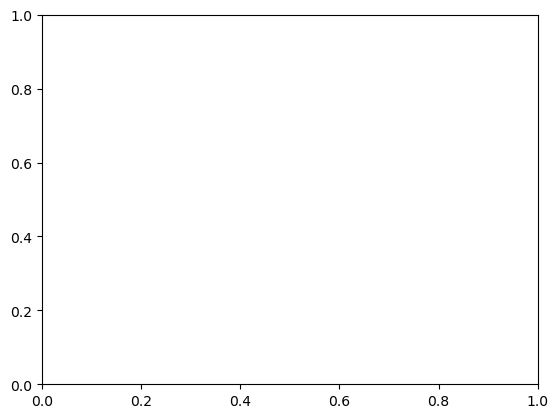

In [34]:
if simulating ==True:
    Running_simulations(da=data, si=simulations, na=names)

if plotting == True:
    Plotting_simualtions(pl = plots, na=names)

if keplers == True:
    Keplers_third(na = names)

In [ ]:
print("finished")